In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
from skimage.morphology import binary_erosion, convex_hull_image, convex_hull_object
from matplotlib.colors import ListedColormap
import math

In [6]:
data = xr.open_dataset('wave2021.nc')
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
mask = data_stat.variables['mask'][0,:,:]
lats = data.variables['latitude'][:]
lons = data.variables['longitude'][:]
lons_mask = data_stat.variables['longitude'][:]
lats_mask = data_stat.variables['latitude'][:]
times = data.variables['time'][:]

july18 = data.sel(time='2021-07-18')
wave = july18.variables['VHM0'][:]


In [7]:
lw = 24
cost = np.zeros_like(wave[:lw])
convex_cost = np.zeros_like(wave[:lw])
contour_raw_meteo = np.zeros_like(wave[:lw])
contour_raw_meteo_convex = np.zeros_like(wave[:lw])
contour_raw_land = np.logical_xor(mask,binary_erosion(mask)) 
for i in range(lw):
    cost[i] = 100 * (np.array(wave[i]) > 0.8)
    convex_cost[i] = convex_hull_object(cost[i])
    contour_raw_meteo[i] = np.logical_xor(cost[i],binary_erosion(cost[i])) 
    contour_raw_meteo_convex[i]=np.logical_xor(convex_cost[i],binary_erosion(convex_cost[i]))


In [8]:
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  
             llcrnrlat=40.58, 
             urcrnrlon=15.13, 
             urcrnrlat=45.5488,  
             resolution='f')
x_min, y_min = mp(8.958334, 41.354168)    # lons.values[650], lats.values[268]
x_max, y_max = mp(11.500001, 43.270832)   # lons.values[711], lats.values[314]

lon, lat = np.meshgrid(lons, lats)   # 62 x 47
x, y = mp(lon, lat)
lon_mask, lat_mask = np.meshgrid(lons_mask, lats_mask)  # 1307 x 380
x_mask, y_mask = mp(lon_mask, lat_mask)

In [68]:
gx2, gy2 = mp(11.1-0.1, 42.5) # argentario

<ipython-input-57-951423f0e8d4>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(x, y, contour_raw_meteo[6], cmap=ListedColormap(['white', 'red']))


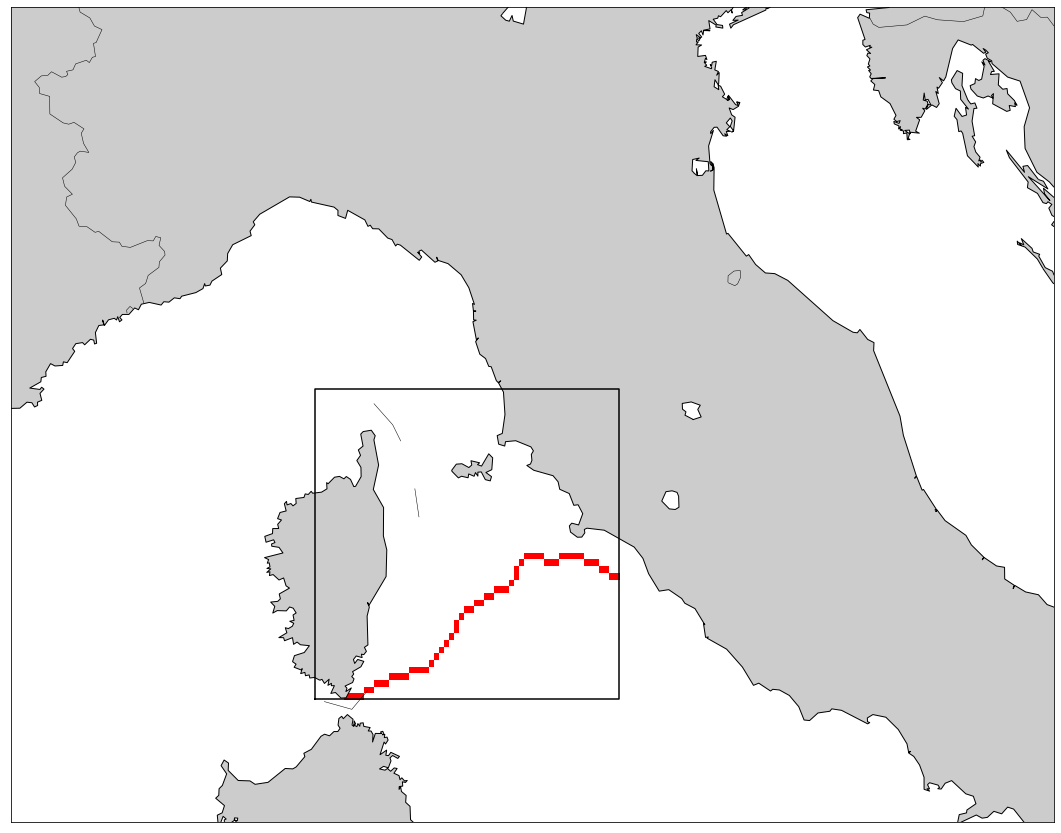

In [57]:
sx, sy = mp(9.54, 42.7)   # bastia
sx2, sy2 = mp(9.44, 41.6) # porto vecchio
gx, gy = mp(10.28, 42.67)  # elba


fig, ax = plt.subplots(1, 1, figsize=(20, 15))
# plt.plot(sx, sy, ">k", markersize=10)
# plt.plot(gx, gy, "Xb", markersize=10)
# plt.plot(sx2, sy2, ">k", markersize=10)
# plt.plot(gx2, gy2, "Xr", markersize=10)
mp.pcolor(x, y, contour_raw_meteo[6], cmap=ListedColormap(['white', 'red']))
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.fillcontinents()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
#plt.savefig('conf_space.png', dpi=500)
plt.show()

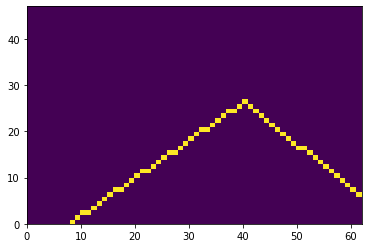

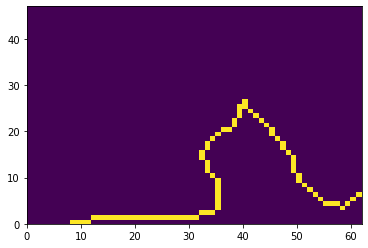

In [27]:
r = 17
plt.figure()
plt.pcolor(contour_raw_meteo_convex[r])

plt.figure()
plt.pcolor(contour_raw_meteo[r])

In [42]:
oxland, oyland = [], []
x_obsl, y_obsl = [], []
Cspacex, Cspacey = [], []
l = 5
oxmeteo, oymeteo = [[] for i in range(l)], [[] for i in range(l)]     # all meteo points
x_obsm, y_obsm = [[] for i in range(l)], [[] for i in range(l)]       # contour meteo points
oxmeteo_, oymeteo_ = [[] for i in range(l)], [[] for i in range(l)]   # all meteo points
x_obsm_, y_obsm_ = [[] for i in range(l)], [[] for i in range(l)]     # contour meteo points

for i in range(5):
    for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
                if contour_raw_meteo[i+3][k][j]:
                    x_obsm[i].append(lons.values[j])
                    y_obsm[i].append(lats.values[k])
    x_obsm_[i], y_obsm_[i] = mp(x_obsm[i], y_obsm[i])     

# land is always static    
for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons_mask.values[650] <= lons_mask.values[j] <= lons_mask.values[711] and lats_mask.values[268] <= lats_mask.values[k] <= lats_mask.values[314]:                      
                if contour_raw_land[k][j]: 
                    x_obsl.append(lons_mask.values[j])
                    y_obsl.append(lats_mask.values[k])
                if mask.values[k][j] == 1:
                    Cspacex.append(lons_mask.values[j])
                    Cspacey.append(lats_mask.values[k])
    
Cspacex_, Cspacey_ = mp(Cspacex, Cspacey)
x_obsl_, y_obsl_ = mp(x_obsl, y_obsl)       # coastline points

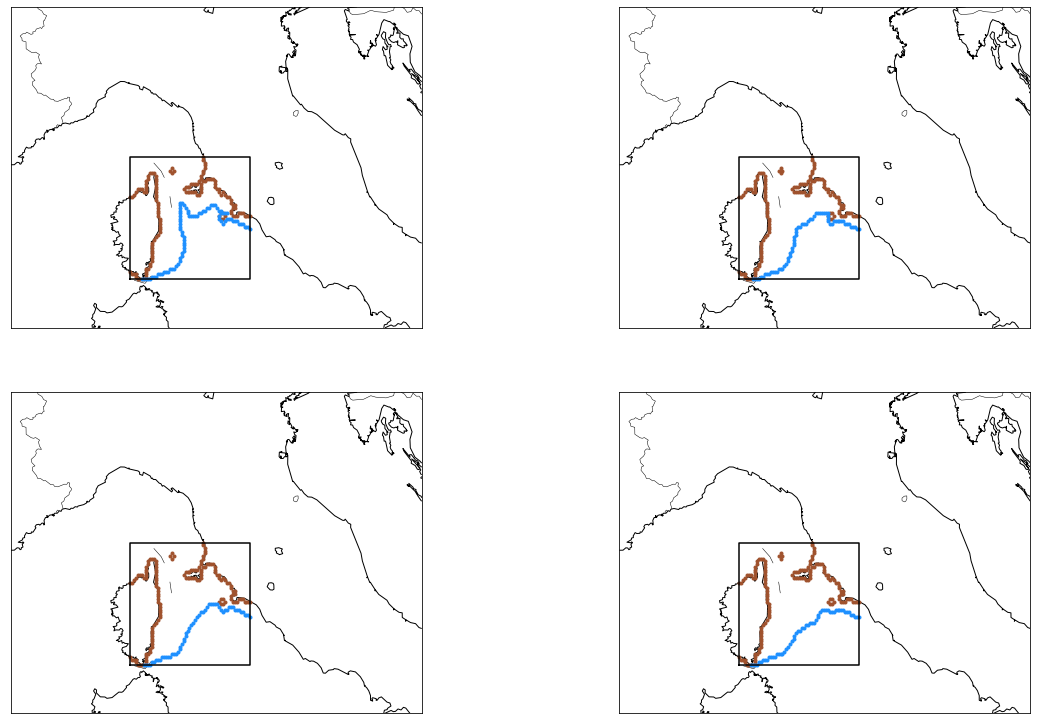

In [59]:
fig, ax = plt.subplots(2, 2, figsize=(20, 13))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  
             llcrnrlat=40.58, 
             urcrnrlon=15.13, 
             urcrnrlat=45.5488, 
             resolution='i', ax=ax[0][0])
mp.plot(x_obsl_, y_obsl_, '.', color="sienna")
mp.plot(x_obsm_[0], y_obsm_[0], ".", color="dodgerblue")
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  
             llcrnrlat=40.58,  
             urcrnrlon=15.13,  
             urcrnrlat=45.5488,  
             resolution='i', ax=ax[0][1])
mp.plot(x_obsl_, y_obsl_, '.', color="sienna")
mp.plot(x_obsm_[1], y_obsm_[1], ".", color="dodgerblue")
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i', ax=ax[1][0])
mp.plot(x_obsl_, y_obsl_, '.', color="sienna")
mp.plot(x_obsm_[2], y_obsm_[2], ".", color="dodgerblue")
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  
             llcrnrlat=40.58,  
             urcrnrlon=15.13,  
             urcrnrlat=45.5488,
             resolution='i', ax=ax[1][1])
mp.plot(x_obsl_, y_obsl_, '.', color="sienna")
mp.plot(x_obsm_[3], y_obsm_[3], ".", color="dodgerblue")
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

plt.savefig('4obstacle.png', dpi=500)

In [61]:
mp = Basemap(projection='merc',
             llcrnrlon=6.42, 
             llcrnrlat=40.58,  
             urcrnrlon=15.13, 
             urcrnrlat=45.5488,  
             resolution='f')

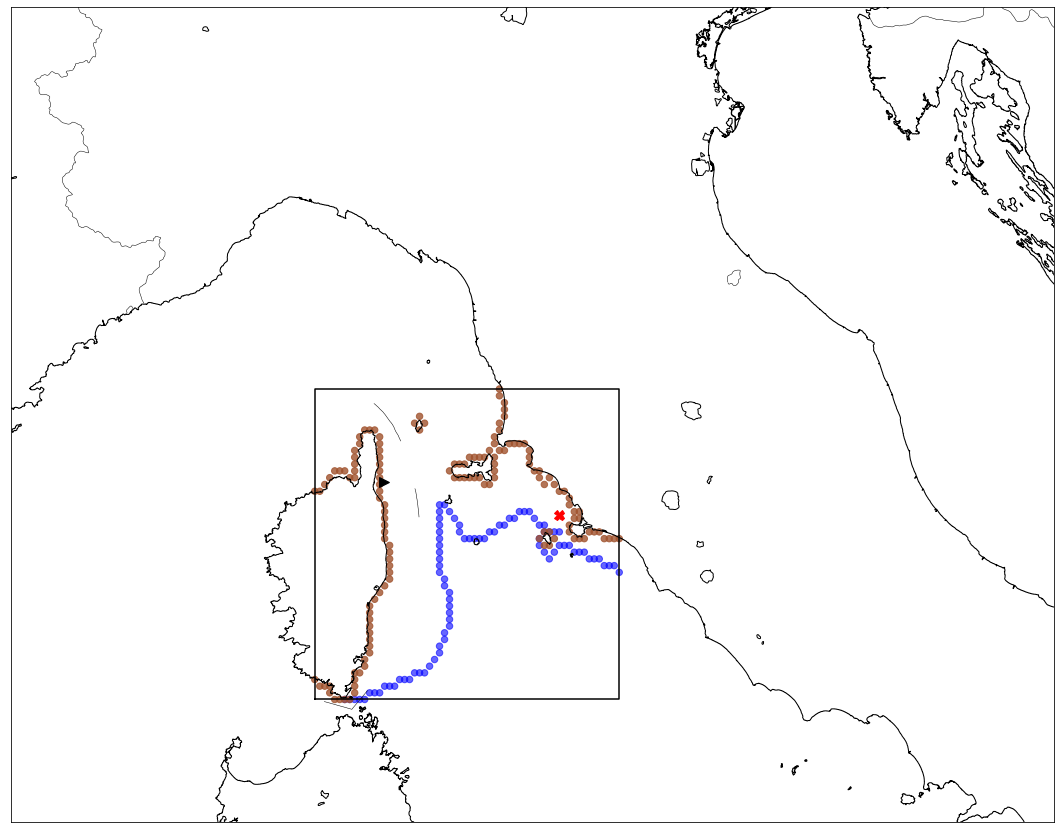

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx2, gy2, "Xr", markersize=10)
for i in range(len(x_obsm_[0])):
    ax.add_patch(plt.Circle(xy=(x_obsm_[0][i], y_obsm_[0][i]), radius=3000,
                            color='b', alpha=0.6))
for i in range(len(x_obsl_)):
    ax.add_patch(plt.Circle(xy=(x_obsl_[i], y_obsl_[i]), radius=3000,
                            color='sienna', alpha=0.8))
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.savefig('4obstacle1.png', dpi=500)
plt.show()